In [1]:
%%bash
data_path=/content/drive/MyDrive/vkr/
# unzip $data_path/non_fires.zip
# unzip $data_path/forest_fires.zip
# cp $data_path/Irkutsk_region.geojson .
cp -r $data_path/train_data .

In [2]:
!pip install keras-tuner
# !pip install shap
# !pip install graphviz
# !pip install scikit-learn==1.4.2
# ! pip list | grep scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.4 MB/s eta 0:00:00


In [3]:
# !pip install mapclassify
import geopandas as gpd
import folium

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz

from calendar import monthrange
import os, json, shutil

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers as rg
import keras_tuner

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import scipy.stats as st
import scipy

# import shap

# from sklearn.preprocessing import MinMaxScaler


In [4]:
train_files_path = "train_data/"

##### Train with all features

In [5]:
# read the test dataset and drop columns to correspond to the training dataset
test_ds = pd.read_csv(train_files_path + "test_dataset_2024.csv", sep=";").drop(columns=["Unnamed: 0"])
test_ds["vegetation_type"] = test_ds["vegetation_type"].astype(int)
print(test_ds.dtypes, test_ds.head(5))

year                 int64
is_fire              int64
soilw40_mean       float64
soilw40_max        float64
soilw40_min        float64
                    ...   
aspect             float64
vegetation_type      int64
road_dist          float64
river_dist         float64
locality_dist      float64
Length: 105, dtype: object    year  is_fire  soilw40_mean  soilw40_max  soilw40_min  soilw40_std  \
0  2024        1      0.260000         0.26         0.26     0.000000   
1  2024        1      0.275625         0.28         0.27     0.005040   
2  2024        1      0.277188         0.28         0.27     0.004568   
3  2024        1      0.268438         0.27         0.26     0.003689   
4  2024        1      0.301562         0.31         0.29     0.006773   

   soilw40_mode_num  soilw40_median  soilw200_mean  soilw200_max  ...  \
0              0.26            0.26           0.45          0.45  ...   
1              0.28            0.28           0.45          0.45  ...   
2              0.2

In [6]:
train_ds = pd.read_csv(train_files_path + "dataset.csv", sep=";").drop(columns=["Unnamed: 0"])
print(train_ds.dtypes, train_ds.shape, train_ds.columns, train_ds.index, sep="\n")
train_ds.head(5)

apcp_mean          float64
rh_mean            float64
t_mean             float64
wind_speed_mean    float64
wind_dir_std       float64
aspect             float64
elevation          float64
slope              float64
locality_dist      float64
river_dist         float64
road_dist          float64
vegetation_type      int64
is_fire              int64
dtype: object
(18279, 13)
Index(['apcp_mean', 'rh_mean', 't_mean', 'wind_speed_mean', 'wind_dir_std',
       'aspect', 'elevation', 'slope', 'locality_dist', 'river_dist',
       'road_dist', 'vegetation_type', 'is_fire'],
      dtype='object')
RangeIndex(start=0, stop=18279, step=1)


,apcp_mean,rh_mean,t_mean,wind_speed_mean,wind_dir_std,aspect,elevation,slope,locality_dist,river_dist,road_dist,vegetation_type,is_fire
0,0.933361,-0.478887,1.140627,-0.220611,0.937307,0.376493,0.591430,0.390830,0.925226,-0.130329,-0.108080,21,1
1,-0.417075,-0.731301,0.907181,-1.324532,1.074557,0.588895,0.725595,0.644836,2.803757,-0.067335,0.070995,1,1
2,-0.609995,0.364651,-0.918104,-0.021905,1.426540,-1.072641,-0.266290,1.563978,2.143343,-1.025714,0.312379,11,1
3,-0.560209,0.318359,-0.818766,0.094007,1.704787,-1.139740,-0.262791,0.028229,1.427412,0.043715,0.463729,15,1
4,-0.288797,-0.648157,1.222554,-0.388158,0.304867,0.648565,1.093033,1.090195,1.716589,-0.405877,0.482076,1,1


Index([ 1093,  1094,  1095,  1096,  1097,  1098,  1099,  1100,  1101,  1102,
       ...
       18269, 18270, 18271, 18272, 18273, 18274, 18275, 18276, 18277, 18278],
      dtype='int64', length=10649)
2804 18279
(2804,)


(is_fire
 0    7845
 1    7630
 Name: count, dtype: int64,
 <Axes: >)

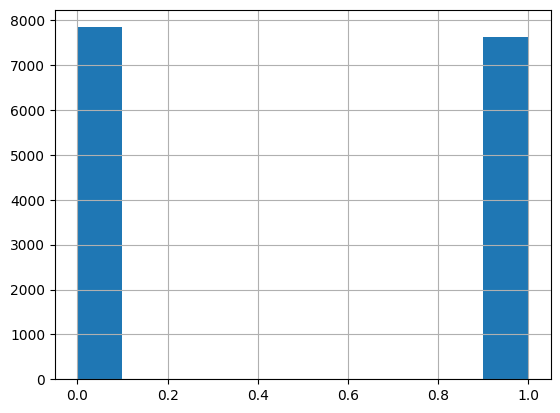

In [7]:
# drop nonfires
drop_nonfires_idx = train_ds[(train_ds.is_fire == 0)].index
assert drop_nonfires_idx.duplicated().sum() == 0
print(drop_nonfires_idx)
idx = drop_nonfires_idx.to_numpy()
np.random.shuffle(idx)
vc = train_ds.is_fire.value_counts()
a = -215
diff = vc[0] - vc[1] + a
print(diff, train_ds.shape[0])
drop_idx = idx[:diff]
print(drop_idx.shape)

train_ds = train_ds.drop(index=drop_idx)
train_ds.is_fire.value_counts(), train_ds.is_fire.hist()

In [8]:
# exclude cols in train_ds
# ex_cols = ["aspect"]
# train_ds = train_ds.loc[:, ~train_ds.columns.isin(ex_cols)]

(   apcp_mean   rh_mean    t_mean  wind_speed_mean  wind_dir_std    aspect  \
 0   0.933361 -0.478887  1.140627        -0.220611      0.937307  0.376493   
 1  -0.417075 -0.731301  0.907181        -1.324532      1.074557  0.588895   
 2  -0.609995  0.364651 -0.918104        -0.021905      1.426540 -1.072641   
 3  -0.560209  0.318359 -0.818766         0.094007      1.704787 -1.139740   
 4  -0.288797 -0.648157  1.222554        -0.388158      0.304867  0.648565   
 
    elevation     slope  locality_dist  river_dist  road_dist  vegetation_type  
 0   0.591430  0.390830       0.925226   -0.130329  -0.108080               21  
 1   0.725595  0.644836       2.803757   -0.067335   0.070995                1  
 2  -0.266290  1.563978       2.143343   -1.025714   0.312379               11  
 3  -0.262791  0.028229       1.427412    0.043715   0.463729               15  
 4   1.093033  1.090195       1.716589   -0.405877   0.482076                1  ,
 0    1
 1    1
 2    1
 3    1
 4    1
 Na

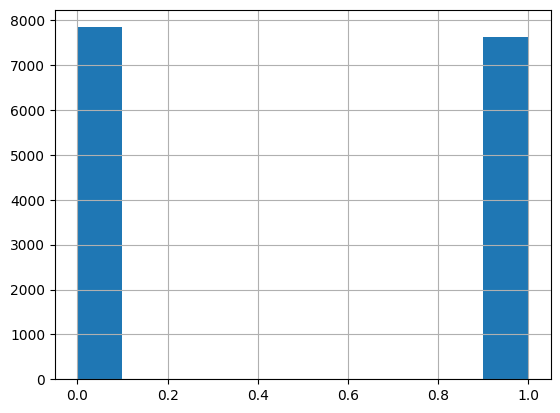

In [9]:
features = train_ds.loc[:, ~train_ds.columns.isin(["is_fire"])]
target = train_ds["is_fire"]
features = features.reset_index(drop=True)
target = target.reset_index(drop=True)
features.head(5), target.head(5), target.hist()

In [10]:
# lets test if vegetation type normalization works

# # plt.hist(features.vegetation_type)
# sc = MinMaxScaler()
# vt = features.vegetation_type.to_numpy().reshape(-1, 1)
# tr = sc.fit_transform(vt).reshape(1, -1)[0]
# transform_ = tr

# transform_ = scipy.special.boxcox1p(tr, 3)
# print(transform_)
# plt.hist(transform_)

# normalize vegetation_type
vt = features.vegetation_type
transform_ = (vt - vt.mean()) / vt.std()
# transform_ = vt

# ex_cols = ["RH", "techno_obj_dist"]
# features_ex = features.loc[:, ~features.columns.isin(ex_cols)]
features_ex = features.copy()
features_ex.vegetation_type = transform_
features_ex.columns, #features_ex.vegetation_type

(Index(['apcp_mean', 'rh_mean', 't_mean', 'wind_speed_mean', 'wind_dir_std',
        'aspect', 'elevation', 'slope', 'locality_dist', 'river_dist',
        'road_dist', 'vegetation_type'],
       dtype='object'),)

In [11]:
# randomly permute train dataset if needed
# rand_idx = np.random.permutation(len(features_ex))
# print(rand_idx)
# # Carefull !!! iloc, that doesn't mean that the index will correspond, check if it's the RangeIndex or not
# features_ex = features_ex.iloc[rand_idx]
# target = target.iloc[rand_idx]

In [12]:
features_ex, target

(       apcp_mean   rh_mean    t_mean  wind_speed_mean  wind_dir_std    aspect  \
 0       0.933361 -0.478887  1.140627        -0.220611      0.937307  0.376493   
 1      -0.417075 -0.731301  0.907181        -1.324532      1.074557  0.588895   
 2      -0.609995  0.364651 -0.918104        -0.021905      1.426540 -1.072641   
 3      -0.560209  0.318359 -0.818766         0.094007      1.704787 -1.139740   
 4      -0.288797 -0.648157  1.222554        -0.388158      0.304867  0.648565   
 ...          ...       ...       ...              ...           ...       ...   
 15470   1.817057  0.096997 -0.648548         0.651487     -0.835641  1.669601   
 15471  -0.256678  1.024166 -1.347439         1.495987     -0.196686  1.393571   
 15472   0.199022  0.549818 -0.487639         1.335919     -0.534805  1.172937   
 15473  -0.609995 -1.642848  0.900869         0.342389      0.850181  0.887994   
 15474   0.827566 -0.968665  0.383727        -0.391719      0.981907  0.455829   
 
        elevat

(   apcp_mean   rh_mean    t_mean  wind_speed_mean  wind_dir_std    aspect  \
 0   0.933361 -0.478887  1.140627        -0.220611      0.937307  0.376493   
 1  -0.417075 -0.731301  0.907181        -1.324532      1.074557  0.588895   
 2  -0.609995  0.364651 -0.918104        -0.021905      1.426540 -1.072641   
 3  -0.560209  0.318359 -0.818766         0.094007      1.704787 -1.139740   
 4  -0.288797 -0.648157  1.222554        -0.388158      0.304867  0.648565   
 
    elevation     slope  locality_dist  river_dist  road_dist  vegetation_type  
 0   0.591430  0.390830       0.925226   -0.130329  -0.108080         1.471653  
 1   0.725595  0.644836       2.803757   -0.067335   0.070995        -2.370346  
 2  -0.266290  1.563978       2.143343   -1.025714   0.312379        -0.449346  
 3  -0.262791  0.028229       1.427412    0.043715   0.463729         0.319054  
 4   1.093033  1.090195       1.716589   -0.405877   0.482076        -2.370346  ,
 0    1
 1    1
 2    1
 3    1
 4    1
 Na

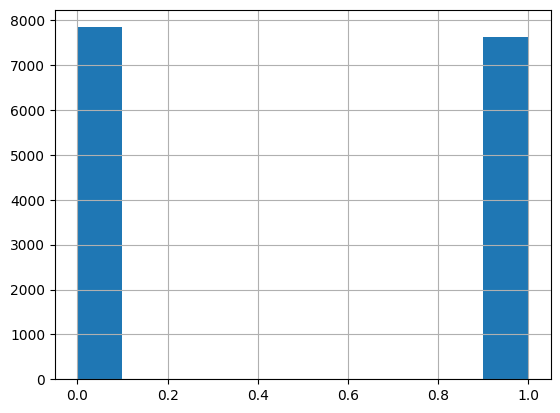

In [13]:
# X_train_ds, X_val_ds, y_train_ds, y_val_ds = train_test_split(features_ex, target, test_size=0.1, random_state=4)
X_train_ds = features_ex.copy()
y_train_ds = target.copy()
X_train_ds.head(5), y_train_ds.head(5), X_train_ds.shape, y_train_ds.shape, y_train_ds.hist()

Prepare the test dataset so that it corresponds to the train ds

Is the X train and X test columns order equal? True
The target name: is_fire
   apcp_mean   rh_mean    t_mean  wind_speed_mean  wind_dir_std    aspect  \
0  -1.156820 -1.322714  0.720074        -0.879516      1.799650  1.924821   
1  -1.055476 -1.510908  1.561793        -0.535203      1.375015 -1.175196   

   elevation     slope  locality_dist  river_dist  road_dist  vegetation_type  
0  -0.872223 -0.797969       1.240938    0.859338   0.907259         0.814251  
1  -0.836417 -0.798585       1.257532    0.928062   0.928147         0.814251  
0       1
1       1
2       1
3       1
4       1
       ..
1543    0
1544    0
1545    0
1546    0
1547    0
Name: is_fire, Length: 1548, dtype: int64


<Axes: >

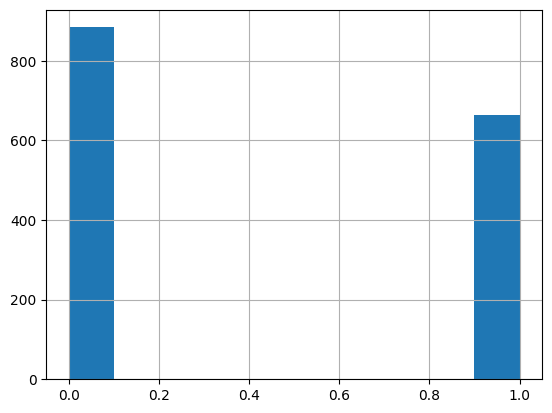

In [14]:
# prepare the test dataset

target_col = target.name
train_ds_cols = X_train_ds.columns.to_list() + [target_col]
test_ds_ = test_ds.loc[:, test_ds.columns.isin(train_ds_cols)]
# print(test_ds_.columns) #, test_ds_.head(1))
# test_ds_.is_fire.hist()

X_test_ds = test_ds_.loc[:, ~test_ds_.columns.isin([target_col])]
# # arrange X_test_ds so that its columns order corresponds to the X_train_ds (carefull! pd.DataFrame)
X_test_ds = X_test_ds.reindex(X_train_ds.columns, axis="columns")
# # assert that no NaN columns appeared after the reindex
assert X_test_ds.isnull().sum().sum() == 0
y_test_ds = test_ds_.loc[:, target_col]
print("Is the X train and X test columns order equal?", (X_train_ds.columns == X_test_ds.columns).all(), )
print("The target name:", y_test_ds.name)
# print(X_train_ds.head(2), X_test_ds.head(2), sep="\n")

# normalize X_test using z-score (like X_train)
# print("*" * 100, "Normalizing the test dataset", sep="\n")
X_test_ds = (X_test_ds - X_test_ds.mean()) / X_test_ds.std()
print(X_test_ds.head(2), y_test_ds, sep="\n")
y_test_ds.hist()

In [15]:
# permute the test dataset
rand_idx_test = np.random.permutation(len(X_test_ds))
X_test_ds = X_test_ds.iloc[rand_idx_test]
y_test_ds = y_test_ds.iloc[rand_idx_test]

In [16]:
X_test_ds.head(5), y_test_ds.head(5)

(      apcp_mean   rh_mean    t_mean  wind_speed_mean  wind_dir_std    aspect  \
 59    -0.023040 -1.224487  0.402905         0.000941      1.727768 -0.995373   
 1453  -0.542425  0.545694 -1.270833         0.251797     -0.595632  1.087980   
 1159  -0.016706  0.843888 -0.780748         0.532166      0.291124  1.138251   
 1037  -0.453750  1.127496 -1.766052         0.640378     -0.724743  0.699824   
 1275  -0.935131 -1.534630  0.432369         0.222284     -0.332026  0.104469   
 
       elevation     slope  locality_dist  river_dist  road_dist  \
 59    -0.535958 -0.136945      -0.859974   -0.117873  -0.240211   
 1453  -0.410770 -0.037226      -1.144309   -0.166332  -0.868723   
 1159  -0.548331 -0.980306      -1.079183   -0.239590  -1.027809   
 1037   0.876403 -0.869970      -1.012548   -0.613827  -0.693477   
 1275  -1.000316 -0.657374       0.164107    1.691501  -0.905273   
 
       vegetation_type  
 59          -0.424328  
 1453        -0.630758  
 1159        -0.424328  
 1

Convert the datasets to the numpy arrays

In [17]:
# if validation dataset is unavailable
# convert x and y train, validation and test datasets to numpy arrays
l = [X_train_ds, y_train_ds, X_test_ds, y_test_ds]
# !!! Attention: preserve the order, it's important
X_train, y_train, X_test, y_test = map(lambda x: x.to_numpy(), l)
print("The datasets shape:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
assert X_train.shape[1] == X_test.shape[1]
# transpose y so that it works with the keras methods
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print("The target train and test arrays after the reshape:", y_train.shape, y_test.shape)

The datasets shape: (15475, 12) (15475,) (1548, 12) (1548,)
The target train and test arrays after the reshape: (15475, 1) (1548, 1)


In [18]:
# comment if you don't need the validation dataset

# # convert x and y train, validation and test datasets to numpy arrays
# l = [X_train_ds, y_train_ds, X_val_ds, y_val_ds, X_test_ds, y_test_ds]
# # !!! Attention: preserve the order, it's important
# X_train, y_train, X_val, y_val, X_test, y_test = map(lambda x: x.to_numpy(), l)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
# assert X_train.shape[1] == X_val.shape[1]
# assert X_train.shape[1] == X_test.shape[1]
# # transpose y so that it works with the keras methods
# y_train = y_train.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)
# print(y_train.shape, y_val.shape, y_test.shape)

In [19]:
# def build_model(layers: int=3):
#   """
#   Description: build the model to use GridSearch
#   Params: the model params we want to tune
#   Returns: the tf.model
#   """
#   input_shape = (X_train.shape[1], )
#   print("Model input shape:", input_shape)
#   model = Sequential()
#   model.add(Input(input_shape))

#   model.add(Dense(512, activation="relu", bias_regularizer=rg.L2(0.01))) #, kernel_regularizer=rg.L2(0.01)))
#   model.add(Dense(64, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
#   model.add(Dense(8, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
#   model.add(Dense(1, activation="sigmoid"))

#   model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "f1_score", tf.metrics.AUC()]) #, "precision", "recall", "f1_score", "auc"])

#   return model

Build and train the model

In [20]:
# example tuner
# tuner = keras_tuner.RandomSearch(
#     hypermodel=tune_params,
#     objective = "val_loss",
#     max_trials = 10,
#     executions_per_trial = 1,
#     overwrite = True,
#     directory = hp_tuner_path,
#     project_name = "fires"
# )
# tuner.search_space_summary()

In [21]:
class ANNModel(keras_tuner.HyperModel):
  """
  The hypermodel class that builds the tf.keras.Sequential model and tunes its hyperparameters
  Params:
  input_shape: tuple - the shape of the train dataset in the following form: (n, ), where n is the
  number of train features
  """

  def __init__(self, input_shape: tuple) -> None:
    self.input_shape = input_shape


  def build_model(self, n_layers: int, n_units: int, learning_rate: float, ) -> tf.keras.Sequential:
    """
    Description: build the model with the defined parameters
    Params: the model parameters we want to tune
    Returns: tf.keras.Sequential model
    """

    print(f"I'm in build_model and I have the following params: {n_layers, n_units, learning_rate}")

    model = Sequential()
    model.add(Input(self.input_shape))

    for i in range(n_layers):
      model.add(Dense(units=n_units, activation="relu", bias_regularizer=rg.L2(0.01))) #, kernel_regularizer=rg.L2(0.01)))

    # model.add(Dense(64, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))
    # model.add(Dense(8, activation="relu", bias_regularizer=rg.L2(0.01))) #kernel_regularizer=rg.L1L2(l1=0.01, l2=0.01)))

    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy", "f1_score", tf.metrics.AUC()] #, "precision", "recall"])
    )

    return model


  def build(self, hp):
    """
    Description: build the model
    Params:
    hp - the hyperparameters class: keras_tuner.HyperParameters()
    Returns: the built model
    """
    # n_layers = hp.Int("n_layers", min_value=3, max_value=12, step=1)
    n_layers = hp.Int("n_layers", min_value=3, max_value=12, step=1)
    # l_rate = hp.Float("l_rate", min_value=1e-8, max_value=1e-5, sampling="log")
    l_rate = hp.Float("l_rate", min_value=1e-5, max_value=1e-2, step=10, sampling="log")
    n_units = hp.Int("n_units", min_value=32, max_value=1024, step=2, sampling="log")
    # n_layers = 11
    # l_rate = 7.04032e-6
    # n_units = 64
    model = self.build_model(n_layers, n_units, l_rate)
    return model


  def fit(self, hp, model, x, y, batch_size = None, validation_split = None, **kwargs):
    """
    Description: fit the model
    Params:
    hp - the hyperparameters class: keras_tuner.HyperParameters()
    model - the model to fit (get in build)
    x, y - train features and train target respectively
    batch_size - the batch size
    validation_split - the validation split
    **kwargs - all the parameters that tf.keras.Model.fit method has
    """

    if batch_size is None:
      batch_size = hp.Choice("b_size", [32, 64, 128, 256, 512])
    print("I'm in fit and the batch size is", batch_size)

    if validation_split is None:
      validation_split = hp.Choice("val_split", [0.2, 0.15, 0.1, 0.25, 0.33])
    print("I'm in fit and the validation split is", validation_split)

    return model.fit(
        x, y,
        batch_size = batch_size,
        validation_split = validation_split,
        **kwargs,
    )

# usage
# input_shape = (X_train.shape[1], )
# hp = keras_tuner.HyperParameters()
# model = ANNModel(input_shape)
# m = model.build(hp)
# model.fit(hp, m, x=X_train, y=y_train)
# m.summary()

In [22]:
# create a path for the tuner
hp_tuner_path = "tuner_dir"
if not os.path.exists(hp_tuner_path):
  print("Creating the directory for the tuner. Path:", hp_tuner_path)
  os.mkdir(hp_tuner_path)

# a couple of variables to use in search and fit
callback_ = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min", start_from_epoch=3)
# if the values are None, tuner will use random search, else the specified value
batch_size_ = None
val_split_ = None

Creating the directory for the tuner. Path: tuner_dir


In [23]:
input_shape = (X_train.shape[1], )
rs_tuner = keras_tuner.RandomSearch(
    ANNModel(input_shape),
    objective="val_loss",
    max_trials=20,
    executions_per_trial = 1,
    overwrite = True,
    directory = hp_tuner_path,
    project_name = "fires"
)
rs_tuner.search(X_train, y_train, epochs=150, batch_size=batch_size_, validation_split=val_split_, callbacks=[callback_])

Trial 20 Complete [00h 00m 12s]
val_loss: 0.45605435967445374

Best val_loss So Far: 0.4117600619792938
Total elapsed time: 00h 10m 05s


In [24]:
rs_tuner.results_summary(), rs_tuner.get_best_hyperparameters()[0], rs_tuner.get_best_models()[0].summary()

Results summary
Results in tuner_dir/fires
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 12 summary
Hyperparameters:
n_layers: 3
l_rate: 0.01
n_units: 32
b_size: 32
val_split: 0.15
Score: 0.4117600619792938

Trial 09 summary
Hyperparameters:
n_layers: 8
l_rate: 0.01
n_units: 256
b_size: 64
val_split: 0.15
Score: 0.42462581396102905

Trial 16 summary
Hyperparameters:
n_layers: 4
l_rate: 0.0001
n_units: 1024
b_size: 32
val_split: 0.25
Score: 0.42860183119773865

Trial 14 summary
Hyperparameters:
n_layers: 7
l_rate: 0.01
n_units: 512
b_size: 128
val_split: 0.33
Score: 0.4363406300544739

Trial 10 summary
Hyperparameters:
n_layers: 11
l_rate: 0.0001
n_units: 512
b_size: 32
val_split: 0.1
Score: 0.43711185455322266

Trial 13 summary
Hyperparameters:
n_layers: 12
l_rate: 0.001
n_units: 256
b_size: 512
val_split: 0.25
Score: 0.44324982166290283

Trial 08 summary
Hyperparameters:
n_layers: 12
l_rate: 0.001
n_units: 512
b_size: 128
val_split: 0.1
Score: 0.44353768229

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

(None,
 None)

In [25]:
hp_model = ANNModel(input_shape)
best_hp_params = rs_tuner.get_best_hyperparameters()[0]
print("Refitting the model with the best hyperparams", best_hp_params.values)
tuned_model = hp_model.build(best_hp_params)
hp_model.fit(
    best_hp_params, tuned_model,
    X_train, y_train, epochs = 150,
    batch_size = batch_size_,
    validation_split = val_split_,
    callbacks = [callback_],
)

Refitting the model with the best hyperparams {'n_layers': 3, 'l_rate': 0.01, 'n_units': 32, 'b_size': 32, 'val_split': 0.15}
I'm in build_model and I have the following params: (3, 32, 0.01)
I'm in fit and the batch size is 32
I'm in fit and the validation split is 0.15
Epoch 1/150
412/412 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7927 - auc_1: 0.8664 - f1_score: 0.6834 - loss: 0.4555 - val_accuracy: 0.7545 - val_auc_1: 0.8267 - val_f1_score: 0.5144 - val_loss: 0.5037
Epoch 2/150
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8153 - auc_1: 0.8932 - f1_score: 0.6838 - loss: 0.4121 - val_accuracy: 0.7722 - val_auc_1: 0.8561 - val_f1_score: 0.5144 - val_loss: 0.4704
Epoch 3/150
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8313 - auc_1: 0.9044 - f1_score: 0.6826 - loss: 0.3911 - val_accuracy: 0.7636 - val_auc_1: 0.8600 - val_f1_score: 0.5144 - val_loss: 0.5001
Epoch 4/150
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8353 - auc_1: 0.9107 - f1_score: 0.6859 

In [26]:
tuned_model.summary()
# tf.keras.utils.plot_model(
#     model=tuned_model, to_file="arch.png",
#     show_layer_activations=True, show_layer_names=True, show_shapes=True,
#     dpi=70
# )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,685 (30.02 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,124 (20.02 KB)

Evaluate the results

In [27]:
# X_test = np.concatenate((X_test, X_train[-1000:]), axis=0)
# y_test = np.concatenate((y_test, y_train[-1000:]), axis=0)

In [28]:
print(tuned_model.evaluate(X_test, y_test))
model.metrics_names

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(1548, 1)
AUC score: 0.8872798887859129


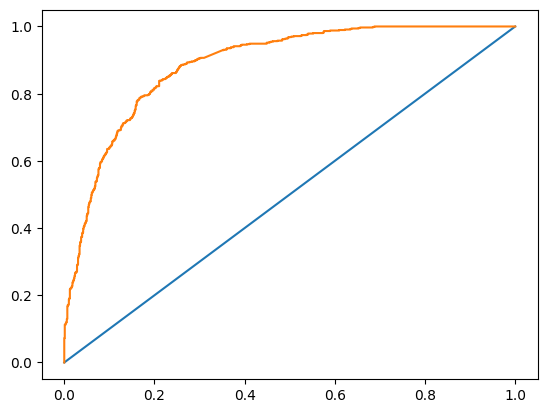

In [38]:
y_pred = tuned_model.predict(X_test)
print(y_pred.shape)
print("AUC score:", roc_auc_score(y_test, y_pred))
fpr, tpr, thresh = roc_curve(y_test, y_pred)
# print("Thresh:", thresh)
# print("FPR, TPR", fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)

In [30]:
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape)
np.unique(y_pred)

(1548, 1)


array([0, 1])

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       884
           1       0.76      0.80      0.78       664

    accuracy                           0.81      1548
   macro avg       0.80      0.81      0.80      1548
weighted avg       0.81      0.81      0.81      1548



<Axes: >

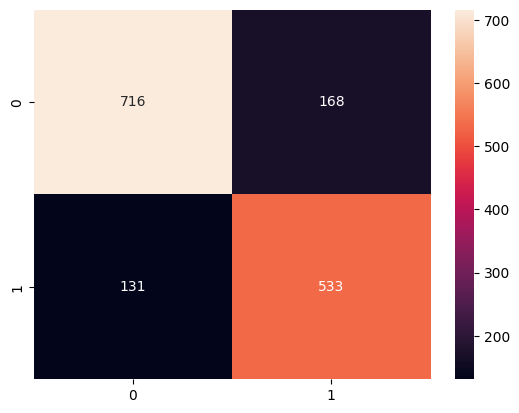

In [31]:
print(classification_report(y_true=y_test, y_pred=y_pred.astype(int)))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred.astype(int))
sns.heatmap(cm, annot=True, fmt="g")

PermutationExplainer explainer: 1549it [03:46,  6.67it/s]
<ipython-input-33-b671294f73c2>:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_val, features=X_test, feature_names=X_train_ds.columns)


(1548, 12)


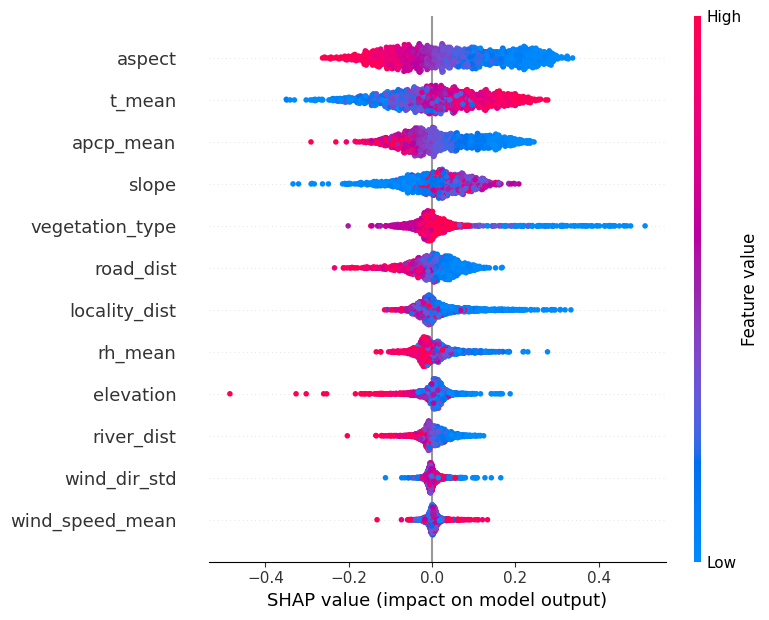

In [33]:
# features importance
# exp = shap.Explainer(tuned_model, X_train[1000:2000], feature_names=X_train_ds.columns)
# shap_val = exp(X_test)
# print(shap_val.shape)
# shap.summary_plot(shap_values=shap_val, features=X_test, feature_names=X_train_ds.columns)

In [34]:
# remove the keras_tuner folder
if os.path.exists(hp_tuner_path):
  print("Removing the hp tuner directory. Path:", hp_tuner_path)
  try:
    shutil.rmtree(hp_tuner_path)
  except Exception as e:
    print(e)

Removing the hp tuner directory. Path: tuner_dir


Save and load model

In [54]:
# examples, don't touch

# # create a path for the saved models
# model_dir_path = "trained_models/"
# if not os.path.exists(model_dir_path):
#   os.mkdir(model_dir_path)


# model_path = model_dir_path + f"model{idx}.keras"
# best_m.save(model_path, include_optimizer=True)

# m1 = tf.keras.models.load_model(model_dir_path, compile=True)

In [ ]:
# tuned_model.save("model.keras", include_optimizer=True)

In [55]:
# loaded_model = tf.keras.models.load_model("model.keras", compile=True)
# loaded_model.summary()

In [56]:
# y_pred = loaded_model.predict(X_test)
# print(y_pred.shape)
# print("AUC score:", roc_auc_score(y_test, y_pred))
# fpr, tpr, thresh = roc_curve(y_test, y_pred)
# # print("Thresh:", thresh)
# # print("FPR, TPR", fpr, tpr)
# plt.plot([0, 1], [0, 1])
# plt.plot(fpr, tpr)

In [57]:
# y_pred = (y_pred > 0.5).astype(int)
# print(y_pred.shape)
# print(np.unique(y_pred))

# print(classification_report(y_true=y_test, y_pred=y_pred.astype(int)))
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred.astype(int))
# sns.heatmap(cm, annot=True, fmt="g")